### Import needed libraries

In [1]:
from pynq import Overlay
from pynq import allocate
import pynq.lib.dma
import numpy as np
import matplotlib.pyplot as plt
import time
from scipy.signal import lfilter

In [2]:
import random

In [2]:
"""
Note:

Xlnk does not support any more, we should use allocate library: from pynq import allocate
"""

'\nfrom pynq import Xlnk\n\nXlnk does not support any more, we should use allocate library: from pynq import allocate\n'

### Plot function for use in this notebook
The first code block below defines a function that we will use for plotting data throughout this notebook. Note that the function has a n_samples argument so that we can limit the number of samples to plot. Plotting more than a few thousand samples can be very slow and consume a lot of RAM.

In [5]:
def plot_to_notebook(time_sec,in_signal,n_samples,out_signal=None):
    plt.figure()
    plt.subplot(1, 1, 1)
    plt.xlabel('Time (usec)')
    plt.grid()
    plt.plot(time_sec[:n_samples]*1e6,in_signal[:n_samples],'y-',label='Input signal')
    if out_signal is not None:
        plt.plot(time_sec[:n_samples]*1e6,out_signal[:n_samples],'g-',linewidth=2,label='FIR output')
    plt.legend()

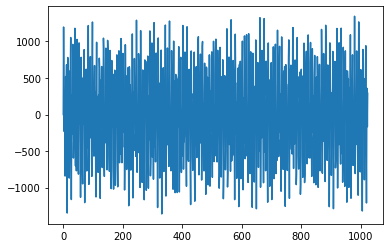

In [3]:
samples = 1024
t = np.linspace(0, 10, samples)

# Frequency that can be between 10 and 1000 and amplitude that can be between 100 and 1000
input_signal = random.uniform(100, 1000)*np.sin((2 * np.pi*random.uniform(10, 50))*t) + random.uniform(100, 1000)*np.sin((2 * np.pi*random.uniform(10, 50))*t) + random.uniform(100, 1000)*np.sin((2 * np.pi*random.uniform(10, 50))*t)
plt.plot(input_signal)

### Generate the Input Signal

The next code block will generate a "noisy" signal that we will use as input to the FIR implementations. The main signal is a 200kHz sinusoid but we have added lower amplitude sinusoids at 46MHz and 12MHz to simulate noise.

Number of samples:  144000


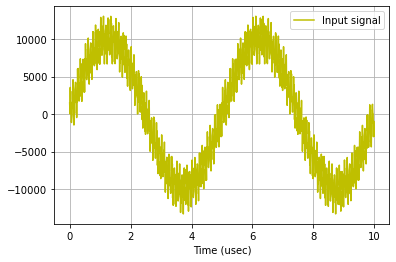

In [4]:
# # Total time
# T = 0.00144

# # Sampling frequency
# fs = 100e6

# # Number of samples
# n = int(T * fs)

# # Time vector in seconds
# t = np.linspace(0, T, n, endpoint=False)

# # Create the signal
# input_signal = 10000*np.sin(0.2e6*2*np.pi*t) + 1500*np.cos(46e6*2*np.pi*t) + 2000*np.sin(12e6*2*np.pi*t)

# # Convert input_signal to 32-bit integers
# input_signal = input_signal.astype(np.int32)

# print('Number of samples: ',len(input_signal))

# # Plot signal to the notebook
# plot_to_notebook(t,input_signal,1000)

### Software FIR filter using SciPy (use lfilter)

Now we use the lfilter function from SciPy to filter the signal using our filter coefficients. The coefficients implement a low pass filter with passband 0-5MHz, and they were generated using this website: http://t-filter.engineerjs.com/

In [7]:
# define the coefficients
coeffs = [-255,-260,-312,-288,-144,153,616,1233,1963,2739,3474,4081,4481,4620,4481,4081,3474,2739,1963,1233,616,153,-144,-288,-312,-260,-255]

start_time = time.time()                               # use time.time() to measure elapsed time
sw_fir_output = lfilter(coeffs,70e3,input_signal)      # FIR filter
stop_time = time.time()
sw_exec_time = stop_time - start_time
print('Software FIR execution time: ',sw_exec_time)

# Plot the result to notebook
plot_to_notebook(sw_fir_output)

Software FIR execution time:  0.0029883384704589844


TypeError: plot_to_notebook() missing 1 required positional argument: 'n_samples'

### Hardware FIR implementation

In the following code blocks, we test out the hardware FIR implementation and measure it's performance.

In [6]:
# Load the overlay
overlay = Overlay('FIR_filter.bit')

# Load the FIR DMA
dma = overlay.filter.fir_dma

In [7]:
# overlay?

Hardware FIR execution time:  0.0057523250579833984
Hardware acceleration factor:  12.042897998093423


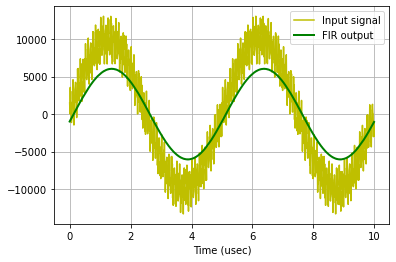

In [9]:
# The pynq.allocate function is used to allocate memory that will be used by IP in the programmable logic.

# Allocate buffers for the input and output signals
in_buffer = allocate(shape=(len(input_signal),),dtype=np.int32)
out_buffer = allocate(shape=(len(input_signal),),dtype=np.int32)

# Copy the input signal to the in_buffer
np.copyto(in_buffer,input_signal)

# Trigger the DMA transfer and wait for the result
start_time = time.time()                        # use time.time() to measure elapsed time
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)
dma.sendchannel.wait()
dma.recvchannel.wait()
stop_time = time.time()
hw_exec_time = stop_time-start_time


print('Hardware FIR execution time: ',hw_exec_time)
print('Hardware acceleration factor: ',sw_exec_time / hw_exec_time)


# Plot to the notebook
plot_to_notebook(t,input_signal,1000,out_signal=out_buffer)

# Free the buffers
in_buffer.close()
out_buffer.close()